# Introduction

Goal of this project is to analyze the number of building permit applications submitted for approval regarding construction of new housing units within the state of Massachusetts.

The intent is to scope, prepare, plot data, seek out any differences \ trends apparent from the analysis, and determine any statistical significance via hypothesis testing.

### Analysis Goals

- Have certain areas boomed prior to the pandemic and then never returned?

- How has the pandemic affected the number of residential building permit applications the state of Massachusetts has seen? Does population / town (or city) size play a role in this?

### Data sources:

The data was obtained from the U.S. Census Bureau webpage: https://www2.census.gov/econ/bps/Place/

Data (in csv format) was downloaded from the northeastern region of the United States between the years 2018 - 2021. Each seperate csv file represent survey data collected by the census bureau for each month.

# Python Module Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os, glob
from scipy.stats import chi2_contingency
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Table of Contents

1. Initial Data Frame Set Up & Inspection
2. Exploratory Data Analysis
3. Data Frame Transformation & Visualizations
4. Hypothesis Testing
5. Time Series Forecasting

# 1. Initial Data Inspection

In [3]:
sample = pd.read_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\monthly_data\ne2001c.txt')
pd.set_option('display.max_columns', None)
sample.head()

,Survey,State,6-Digit,County,Census Place,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Footnote,Central,Zip,Region,Division,Source,Place,Unnamed: 17,1-unit,Unnamed: 19,Unnamed: 20,2-units,Unnamed: 22,Unnamed: 23,3-4 units,Unnamed: 25,Unnamed: 26,5+ units
Date,Code,ID,Code,Code,Code,Code,,Code,Code,Code,City,Code,Code,Code,Code,Name,Bldgs,Units,Value,Bldgs,Units,Value,Bldgs,Units,Value,Bldgs,Units,Value
202001,09,001000,013,,00000,01080,3303,278,25540,,,06232,1,1,3,Andover town,0,0,0,0,0,0,0,0,0,0,0,0
202001,09,013000,003,,00000,02060,18098,278,25540,,,06001,1,1,1,Avon town,0,0,0,0,0,0,0,0,0,0,0,0
202001,09,029000,003,,00000,04300,19866,278,25540,,,06037,1,1,3,Berlin town,0,0,0,0,0,0,0,0,0,0,0,0
202001,09,037000,001,,00000,04720,18584,408,14860,,,06801,1,1,5,Bethel town,4,4,1224766,0,0,0,0,0,0,0,0,0


In [4]:
sample.to_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\test.csv',header = True)

We see that due to heading format in txt file, part of the column name imports as a row of data. We will need to combine all files into data frame, rename columns and delete rows with the column info in it.

### Combining all txt files into data frame

In [5]:
#Define folder pather containing txt data files
files_folder = r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\monthly_data'
files = []

In [6]:
#Create dataframe list using list comprehension for all csv files in project folder
#Skipinitialspace command removes all the unnecessary blank white spaces within each cell
files = [pd.read_csv(file, delimiter = ',', skipinitialspace = True)\
         for file in glob.glob(os.path.join(files_folder, '*.txt'))]

In [7]:
#Creating column names in correct order
column_names = ['date','State','6-Digit','County','Census Place','FIPS Place', \
                'FIPS MCD','Pop','CSA','CBSA','Footnote','Central','Zip','Region', \
                'Division','Source','Place','1-unit_bldgs','1-unit_units','1-unit_value',\
                '2-units_bldgs','2-unit_units','2-unit_value',\
                '3-4-units_bldgs','3-4-unit_units','3-4-unit_value',\
                '5_plus-units_bldgs','5_plus-units_units','5_plus-units_value']

In [8]:
raw_files_df = pd.concat(files).reset_index()

In [9]:
#renaming column names to correct order
raw_files_df.columns = column_names

#removing first row of data that contains column name info
files_df = raw_files_df[raw_files_df.date != 'Date']

#converting date column to datetime data type
files_df['date'] = pd.to_datetime(files_df.loc[:,'date'], format = '%Y%m')

#removing unnecessary columns
files_df.drop(['Census Place', 'Footnote', 'Central','Region', 'Division', 'Source' ], axis = 1 , inplace = True)

In [10]:
files_df.head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value
1,2010-01-01,09,001000,013,NaN,01080,3036.0,278,25540,06232,Andover town,0,0,0,0,0,0,0,0,0,0,0,0
2,2010-01-01,09,005000,009,01150,01220,18554.0,408,35300,064011855,Ansonia,0,0,0,0,0,0,0,0,0,0,0,0
3,2010-01-01,09,009000,015,NaN,01430,4098.0,999,99999,06278,Ashford town,0,0,0,0,0,0,0,0,0,0,0,0
4,2010-01-01,09,013000,003,NaN,02060,15832.0,278,25540,06001,Avon town,2,2,783740,0,0,0,0,0,0,0,0,0
5,2010-01-01,09,029000,003,NaN,04300,18215.0,278,25540,06037,Berlin town,3,3,411954,0,0,0,0,0,0,0,0,0


## Classifying each Place based on population size
(https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf)

**Urbanized Areas (UAs)**
A UA is a continuously built-up area with a population of 50,000 or more.
It comprises one or more places—central place(s)—and the adjacent
densely settled surrounding area—urban fringe—consisting of other
places and nonplace territory.

**Urban Places Outside of UAs (UP)**
Outside of UAs, an urban place is any incorporated place or census designated place (CDP) with at least 2,500 inhabitants. A CDP is a densely
settled population center that has a name and community identity, and
is not part of any incorporated place (see Chapter 9, “Places”).

**Rural Places and Territory (R)**
Territory, population, and housing units that the Census Bureau does
not classify as urban are classified as rural. For instance, a rural place is
any incorporated place or CDP with fewer than 2,500 inhabitants that is
located outside of a UA. A place is either entirely urban or entirely rural,
except for those designated as an extended city.


In [11]:
files_df['classif'] = files_df['Pop'].apply(lambda val: 'UA' if val >= 50000\
                                         else ('UP' if (val >= 2500 and val < 50000)
                                         else 'R'))

In [12]:
files_df.head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value,classif
1,2010-01-01,09,001000,013,NaN,01080,3036.0,278,25540,06232,Andover town,0,0,0,0,0,0,0,0,0,0,0,0,UP
2,2010-01-01,09,005000,009,01150,01220,18554.0,408,35300,064011855,Ansonia,0,0,0,0,0,0,0,0,0,0,0,0,UP
3,2010-01-01,09,009000,015,NaN,01430,4098.0,999,99999,06278,Ashford town,0,0,0,0,0,0,0,0,0,0,0,0,UP
4,2010-01-01,09,013000,003,NaN,02060,15832.0,278,25540,06001,Avon town,2,2,783740,0,0,0,0,0,0,0,0,0,UP
5,2010-01-01,09,029000,003,NaN,04300,18215.0,278,25540,06037,Berlin town,3,3,411954,0,0,0,0,0,0,0,0,0,UP


In [13]:
#changing all appropriate values to float values. "Errors = Ignore" insures all values that are suppose to be objects
#(e.g. city names) are still object data types.

for column in files_df.columns:
    files_df[column] = files_df[column].astype(int, errors = 'ignore')

In [14]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382712 entries, 1 to 382858
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                382712 non-null  datetime64[ns]
 1   State               382712 non-null  int32         
 2   6-Digit             382712 non-null  int32         
 3   County              382712 non-null  int32         
 4   FIPS Place          293701 non-null  object        
 5   FIPS MCD            382065 non-null  object        
 6   Pop                 382098 non-null  float64       
 7   CSA                 382712 non-null  int32         
 8   CBSA                382712 non-null  int32         
 9   Zip                 382712 non-null  object        
 10  Place               382712 non-null  object        
 11  1-unit_bldgs        382712 non-null  int32         
 12  1-unit_units        382712 non-null  int32         
 13  1-unit_value        382712 no

In [15]:
#Convert Survey Column to a data-time data type
files_df['year'] = pd.DatetimeIndex(files_df['date']).year
files_df['month'] = pd.DatetimeIndex(files_df['date']).month

In [16]:
files_df.head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value,classif,year,month
1,2010-01-01,9,1000,13,NaN,01080,3036.0,278,25540,06232,Andover town,0,0,0,0,0,0,0,0,0,0,0,0,UP,2010,1
2,2010-01-01,9,5000,9,01150,01220,18554.0,408,35300,064011855,Ansonia,0,0,0,0,0,0,0,0,0,0,0,0,UP,2010,1
3,2010-01-01,9,9000,15,NaN,01430,4098.0,999,99999,06278,Ashford town,0,0,0,0,0,0,0,0,0,0,0,0,UP,2010,1
4,2010-01-01,9,13000,3,NaN,02060,15832.0,278,25540,06001,Avon town,2,2,783740,0,0,0,0,0,0,0,0,0,UP,2010,1
5,2010-01-01,9,29000,3,NaN,04300,18215.0,278,25540,06037,Berlin town,3,3,411954,0,0,0,0,0,0,0,0,0,UP,2010,1


According to census bureau, the state code for MA = 25. Select data only assigned to this code

In [17]:
ma_df = files_df.query('State == 25').reset_index(drop = True)

In [18]:
#Creating additional column which sums the total amount of buildings independent on the number of units a building contains
ma_df['total_buildings'] = ma_df['1-unit_bldgs'] + ma_df['2-units_bldgs']+ ma_df['3-4-units_bldgs'] \
                        + ma_df['5_plus-units_bldgs']

#Creating extra column adding up number of 2,3,4 unit buildings. This will help us in our analysis later on when we break 
#out our analysis in terms of single family homes, small condos, and large condos
ma_df['total_small_units'] = ma_df['2-unit_units']+ ma_df['3-4-unit_units']

In [20]:
#Loading in county key to identify county name by number listed in main data frame
county_key_df = pd.read_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\st25_ma_cou_csv.csv')

In [21]:
ma_df = ma_df.merge(county_key_df, how = 'left', on = 'County')

In [22]:
ma_df.to_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_results\ma_df.csv',index=False,header = True)

# 2. Exploratory Data Analysis

In [23]:
#obtaining unique years in data set
years = ma_df.year.unique()
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022], dtype=int64)

In [24]:
#obtaining a count of how many urban places, urban areas and rural places there are in the data set
ma_df.query('year == 2018 and month ==1')['classif'].value_counts()

UP    159
UA     22
R       8
Name: classif, dtype: int64

In [25]:
#Determining the shape of the population within the MA data set
ma_df.query('year == 2018 and month ==1')['Pop'].describe()

count       189.000000
mean      25845.153439
std       48353.223448
min          75.000000
25%        8183.000000
50%       15873.000000
75%       28602.000000
max      617594.000000
Name: Pop, dtype: float64

### View distribution of building permits per year by County

In [26]:
county_dist = pd.pivot_table(ma_df, index = ['county_name', 'year'],
                             values = 'total_buildings', aggfunc = np.sum).reset_index()

### View distribution of building permits per month for each year

In [27]:
ma_df_piv = pd.pivot_table(ma_df, 
                           index = ['date','year', 'month', 'classif'], 
                           values = ['total_buildings'], aggfunc = np.sum).reset_index()

In [28]:
ma_df_piv.head()

,date,year,month,classif,total_buildings
0,2010-01-01,2010,1,R,2
1,2010-01-01,2010,1,UA,61
2,2010-01-01,2010,1,UP,238
3,2010-02-01,2010,2,R,3
4,2010-02-01,2010,2,UA,51


### COVID-19 Important Mile Stone: MA State of Emergency

On March 10, 2020, Gov. Charlie Baker declared a state of emergency as cases of COIVD-19 began to spike in Massachusetts. This is the approx. start when COVID restrictions began. We will use this date as a marker in the analysis to determine how the application submission rate has been affected.

Source: https://www.nbcboston.com/life-in-lockdown/life-in-lockdown-a-timeline-of-the-covid-shutdown-in-massachusetts/2320541/

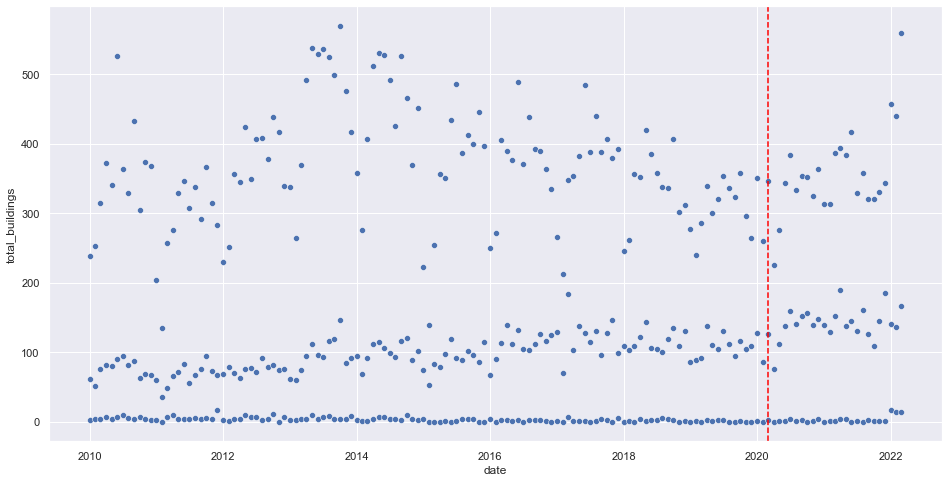

In [29]:
sns.set(style = 'darkgrid')
plt.figure(figsize = (16,8))

sns.scatterplot(
    x = ma_df_piv.date, y = ma_df_piv.total_buildings)

#red vertical line indicates start date of COVID-19 restrictions
plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--')

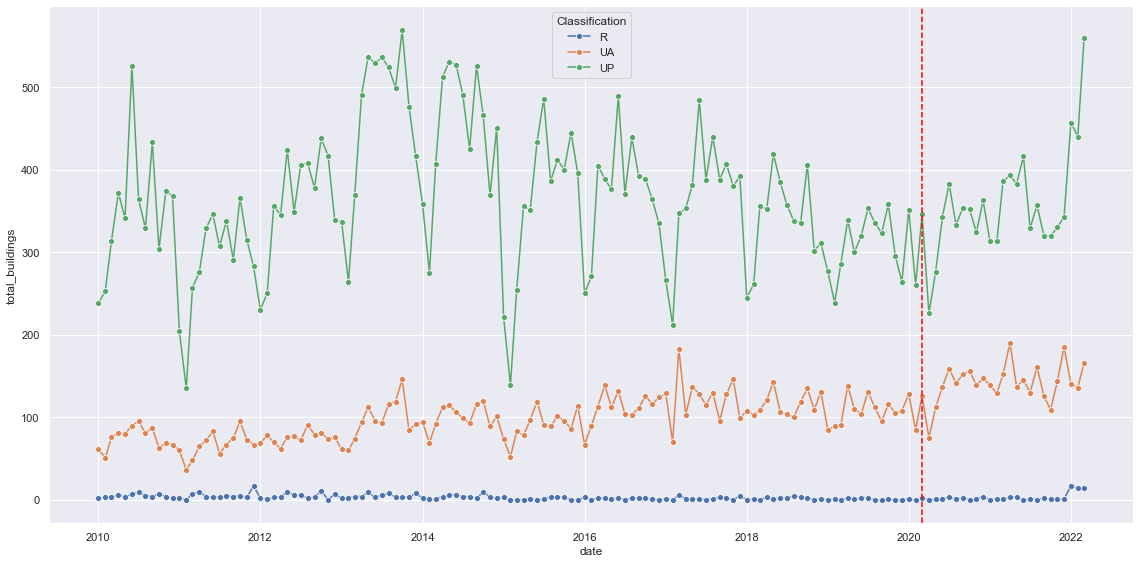

In [30]:
sns.set(style = 'darkgrid')

sns.relplot(
    x = ma_df_piv.date, y = ma_df_piv.total_buildings, hue = ma_df_piv.classif,
    kind = 'line', marker = 'o',
    height = 8, aspect = 2, facet_kws={'legend_out': False})
plt.legend(title = 'Classification', loc = 'best', labels = ['R', 'UA', 'UP'])
#red vertical line indicates start date of COVID-19 restrictions
plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--')

### Initial Observations

It appears that number of applications is dependent on population size. From plotting the initial data set as a scatter plot, we can observe the data tends to cluster in three groups. Based on this information, the data was grouped by place size (Urban Area - UA, Urban Place - UP, Rural - R) then plotted, confirming our initial observation.

A seperate plot was created below for building application submissions for Rural places in order to get an enhanced view. 

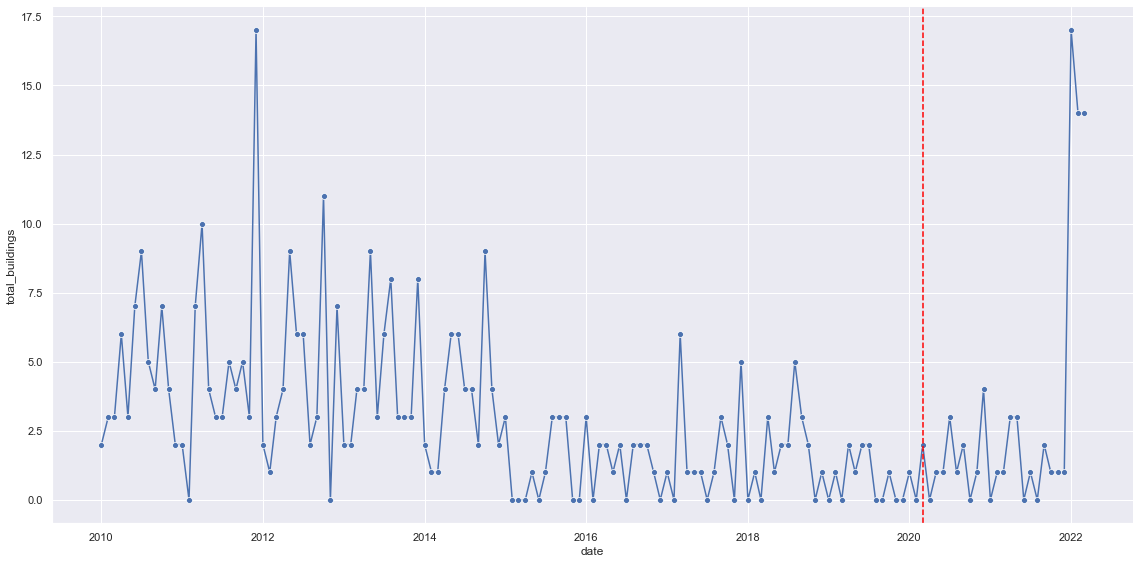

In [31]:
sns.set(style = 'darkgrid')


sns.relplot(data = ma_df_piv[ma_df_piv.classif=='R'],
    x = 'date', y = 'total_buildings', 
    kind = 'line', marker = 'o',
    height = 8, aspect = 2)

#red vertical line indicates start date of COVID-19 restrictions
plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--')

# 3. Data Frame Transformation & Visualizations

First we want to grab all top ten cities / places within Massachusetts that received the most building permit applications throughout each year.

We will then compile the list of unique cities that made the top ten criteria and query the main data frame to show results for only these cities. This will then allow us to track the number of permit applications throughout the remaining years.

In [32]:
#obtaining unique years in data set
years = ma_df.year.unique()
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022], dtype=int64)

In [33]:
#create new dictionary, relating unique years to their own data frame (that is empty)
yeardict = {year:pd.DataFrame() for year in years}

#assigning subset of main dataframe (based on specified year) to empty dataframes created in the new dictionary above
for key in yeardict.keys():
    yeardict[key] = ma_df[:][ma_df.year == key]

In [34]:
yeardict[2021].head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value,classif,year,month,total_buildings,total_small_units,county_name
27622,2021-01-01,25,1000,23,00000,00170,15985.0,148,14460,02351,Abington town,1,1,295385,0,0,0,0,0,0,1,5,708333,UP,2021,1,2,0,Plymouth County
27623,2021-01-01,25,3000,17,00000,00380,21924.0,148,14460,01720,Acton town,2,2,778176,0,0,0,0,0,0,0,0,0,UP,2021,1,2,0,Middlesex County
27624,2021-01-01,25,5000,5,00000,00520,10303.0,148,39300,02743,Acushnet town,3,3,1200000,0,0,0,0,0,0,0,0,0,UP,2021,1,3,0,Bristol County
27625,2021-01-01,25,11000,3,00000,00975,494.0,999,38340,01230,Alford town,0,0,0,0,0,0,0,0,0,0,0,0,R,2021,1,0,0,Berkshire County
27626,2021-01-01,25,13000,9,01260,01260,16283.0,148,14460,01913,Amesbury Town,1,1,203242,0,0,0,0,0,0,0,0,0,UP,2021,1,1,0,Essex County


## Scope Limitations

For the purpose of this EDA, we will be looking at permit data within the past 4 years

In [35]:
topbuild2018 = yeardict[2018].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2019 = yeardict[2019].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2020 = yeardict[2020].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2021 = yeardict[2021].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild = pd.concat([topbuild2018, topbuild2019, topbuild2020, topbuild2021], ignore_index = False, axis = 0)

In [36]:
topbuild

year  Place           
2018  Plymouth town       413
      Boston              237
      Hopkinton town      104
      Needham town        103
      Methuen Town         87
      Dartmouth town       70
      Lexington town       70
      Taunton              67
      Kingston town        66
      Holliston town       64
2019  Plymouth town       406
      Boston              222
      Hopkinton town      117
      Needham town        100
      Methuen Town         92
      Attleboro            86
      Franklin Town        81
      Taunton              66
      Lexington town       64
      Kingston town        63
2020  Plymouth town       435
      Medford             224
      Boston              180
      Hopkinton town      157
      Franklin Town        95
      Acton town           90
      Bridgewater Town     86
      Needham town         85
      Attleboro            82
      Taunton              81
2021  Plymouth town       520
      Medford             289
      Boston     

In [37]:
#changing grouped series into dataframe for further data processing and visualization
topbuilddf = topbuild.to_frame()

toptenbuildpiv = topbuilddf.pivot_table(\
                         index = 'Place',
                         columns = 'year',
                         values = 'total_buildings')

In [38]:
#create list of unique places
top_place_build = toptenbuildpiv.index.unique().tolist()

#query ma_df to show data for only cities that showed up in any top 10 search between years 2018-2021
ma_df_topbuild = ma_df.query('Place in @top_place_build & year in [2018,2019,2020,2021]')

ma_df_topbuild_piv = ma_df_topbuild.pivot_table(\
                                               index = 'Place',
                                               columns = 'year',
                                               values = 'total_buildings',
                                               aggfunc = np.sum)

In [39]:
ma_df_topbuild_piv

year,2018,2019,2020,2021
Place,,,,
Acton town,36.0,22.0,90.0,63.0
Attleboro,58.0,86.0,82.0,55.0
Boston,237.0,222.0,180.0,183.0
Bridgewater Town,NaN,48.0,86.0,55.0
Dartmouth town,70.0,55.0,44.0,34.0
Franklin Town,50.0,81.0,95.0,111.0
Holliston town,64.0,40.0,37.0,32.0
Hopkinton town,104.0,117.0,157.0,169.0
Kingston town,66.0,63.0,62.0,51.0


In [40]:
ma_df_topbuild.query('year == 2018 and month ==1')['classif'].value_counts()

UP    12
UA     4
Name: classif, dtype: int64

### Observations

When looking at all of the cities / towns in our top ten list, it is mostly comprised of places categorized as Urban Places followed by Urban Areas. This is most likely due to the fact that the Urban Places are not as densely populated and have more land available for development. 

Urban Areas such as Boston or Cambridge are scarce in terms of available land for new construction. Typically it is more cost efficient to renovate existing structures within Urban Areas. This data however is outside the scope of this analysis. This observation will be the basis of analysis when performing hypothesis testing in section 4 of this note book.

## Creating Data Visualizations 

Performing data visualizations for gross numbers of buildings constructed 

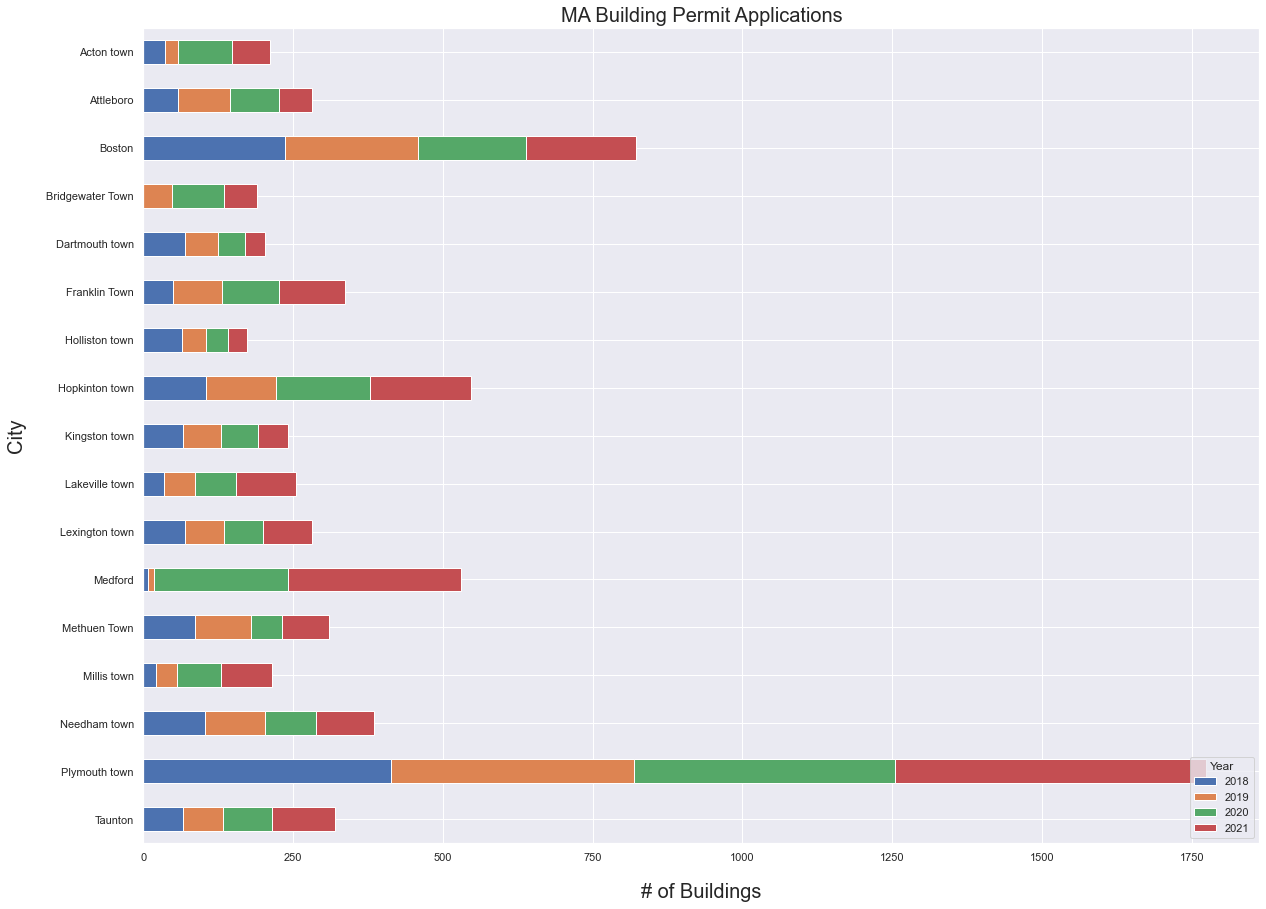

In [41]:
ax = ma_df_topbuild_piv.plot.barh(stacked = True, \
                        figsize = [20,15], \
                        title = 'MA Building Permit Applications')

ax.set_xlabel('# of Buildings', fontsize = 20, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('City', fontsize = 20, labelpad = 20)
plt.yticks(rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
ax.set_title('MA Building Permit Applications', fontsize = 20)
ax.legend(title = 'Year', loc = 4)

In [42]:
top_places = ma_df_topbuild['Place'].unique()

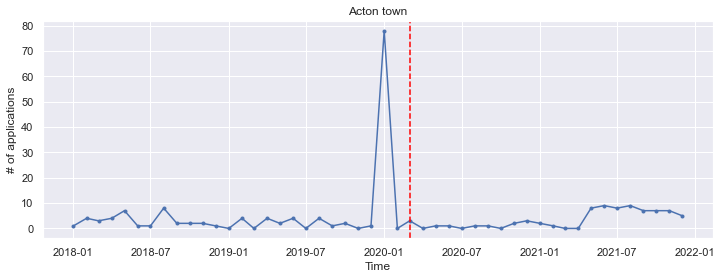

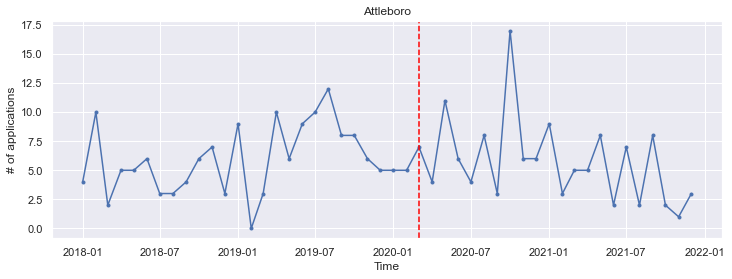

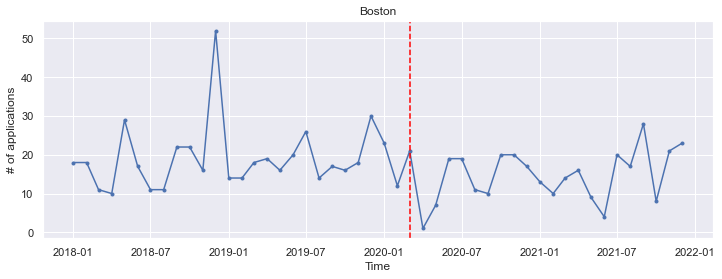

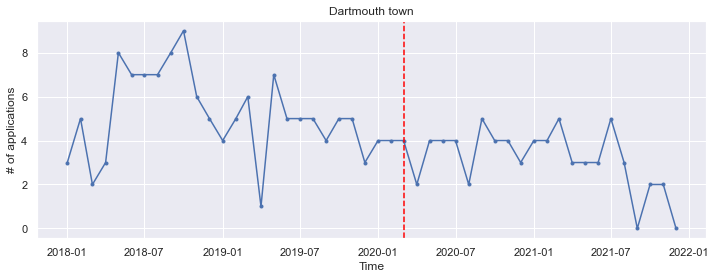

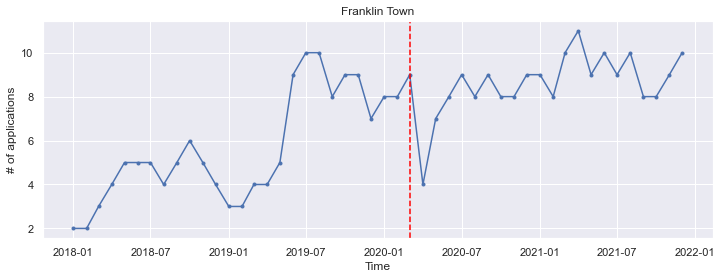

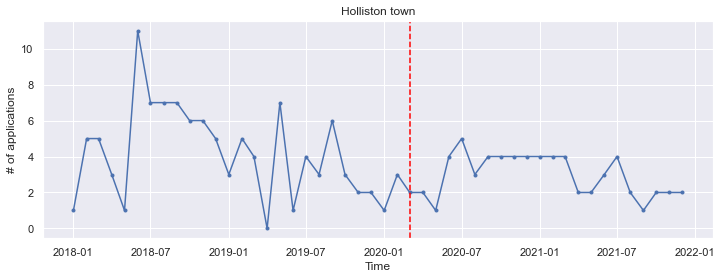

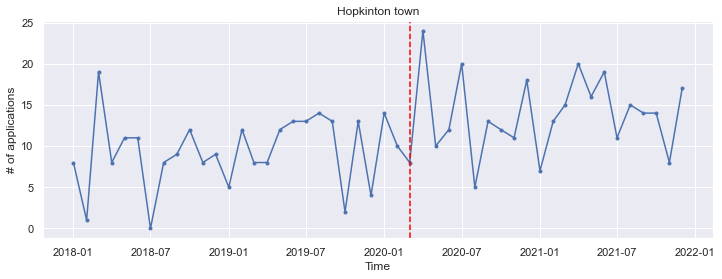

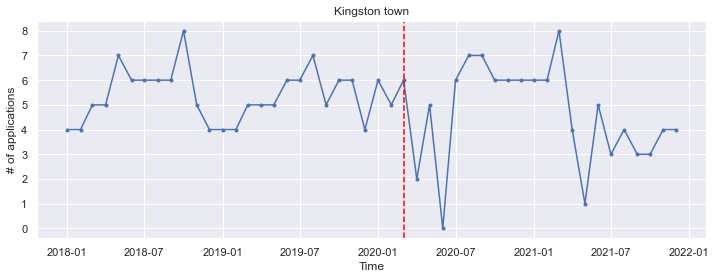

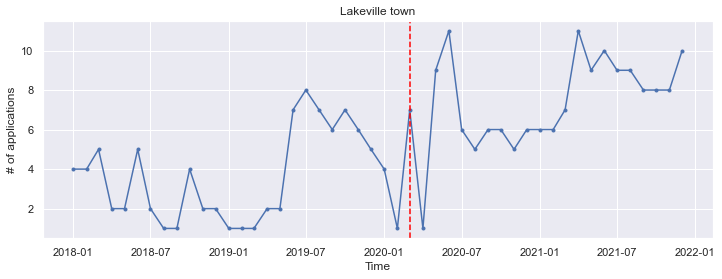

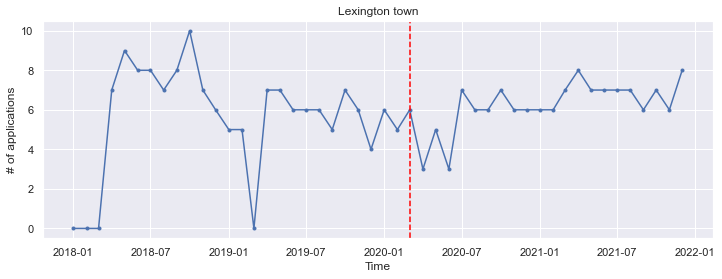

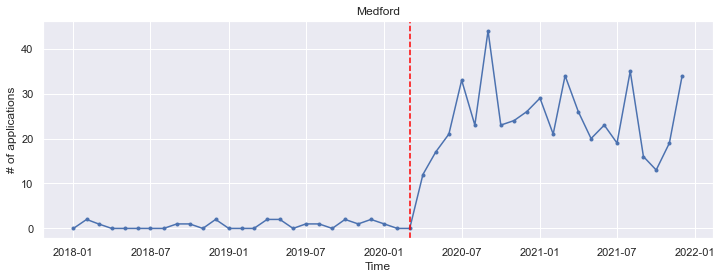

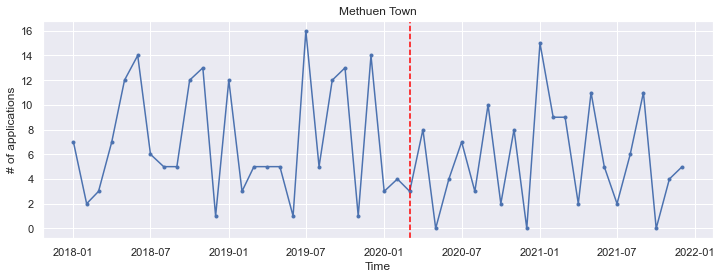

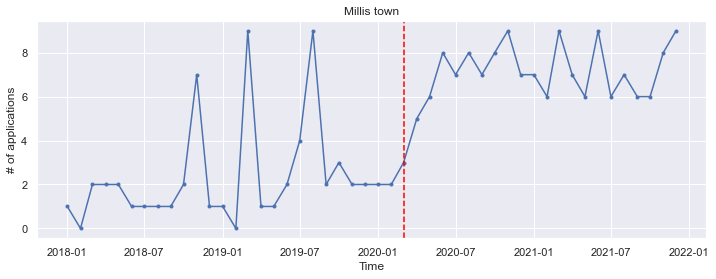

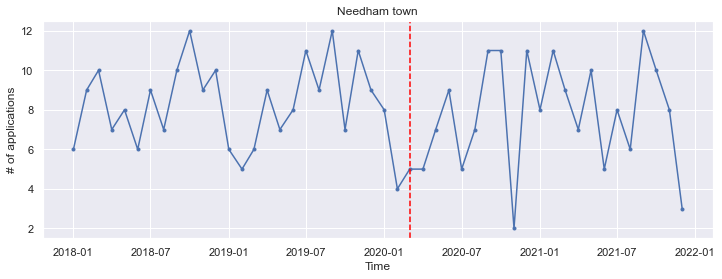

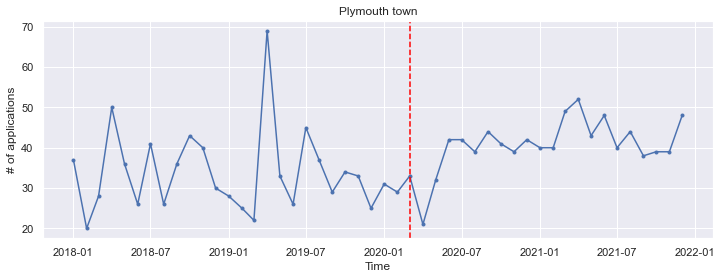

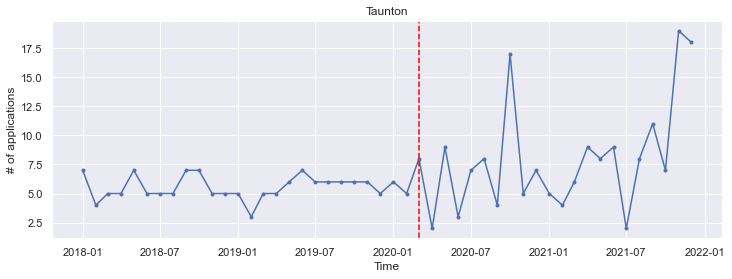

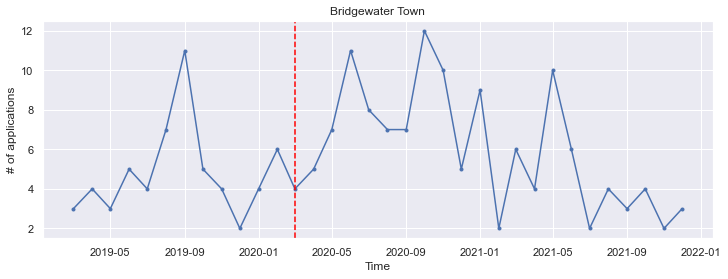

In [43]:
#plotting applications vs time for each of these top places

for i in range(len(top_places)):
    fig, ax = plt.subplots(figsize = (12,4))
    ax.plot('date', 'total_buildings', data = ma_df_topbuild[ma_df_topbuild.Place == top_places[i]], marker = '.')
    plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--')
    ax.set_xlabel('Time')
    ax.set_ylabel('# of applications')
    ax.set_title(top_places[i])

plt.show()

### Two note worthy initial observations:

- Acton Town appears to have a data entry error showing 75 applications submitted right before the start of 2020. It was confirmed this appeared to be a data entry error by looking at the raw csv files.

- Typically we see a sharp decline in building permit applications when the State of Emergency was declared. However there area  few select places that saw the exact opposite behavior such as Medford, Bridgewater, Millis. It is hypothesized that development plans have long been established in these areas and building permits were trying to get approved ASAP before the building department put a pause on accepting new applications.

- Medford is a good example. Due to the fact that the new green line train extension was passing through Medford, development has been rapidly ramping up since the news was confirmed. As a result, the city has seen the smallest impact of permit submission applications due to COVID-19.

## Break out visualization for single family, small and large multi-unit homes

We have just looked at gross number of permit applications for buildings and indiv. units. Lets perform the analysis for single family homes, small multi-unit homes < 5 units, and large multi-unit homes > 5 units.

In [44]:
#single family home dataframe extraction & processing

top_single_df = ma_df_topbuild[ma_df_topbuild['1-unit_bldgs']>= 1]
top_small_df = ma_df_topbuild[ma_df_topbuild['total_small_units']>= 1]
top_large_df = ma_df_topbuild[ma_df_topbuild['5_plus-units_bldgs']>= 1]

In [45]:
top_single_df.head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value,classif,year,month,total_buildings,total_small_units,county_name
20819,2018-01-01,25,3000,17,00000,00380,21924.0,148,14460,01720,Acton town,1,1,427599,0,0,0,0,0,0,0,0,0,UP,2018,1,1,0,Middlesex County
20828,2018-01-01,25,31000,5,02690,02690,43593.0,148,39300,02703,Attleboro,4,4,940300,0,0,0,0,0,0,0,0,0,UP,2018,1,4,0,Bristol County
20837,2018-01-01,25,73000,25,07000,07000,617594.0,148,14460,02118,Boston,2,2,535675,4,8,1140000,2,7,2465000,10,375,100008236,UA,2018,1,18,15,Suffolk County
20856,2018-01-01,25,149000,5,00000,16425,34032.0,148,39300,02747,Dartmouth town,3,3,1012000,0,0,0,0,0,0,0,0,0,UP,2018,1,3,0,Bristol County
20872,2018-01-01,25,213000,21,25172,25100,31635.0,148,14460,02038,Franklin Town,2,2,618715,0,0,0,0,0,0,0,0,0,UP,2018,1,2,0,Norfolk County


In [46]:
top_singlepiv = top_single_df.pivot_table(index = 'Place', columns = 'year', values = '1-unit_bldgs', aggfunc = np.sum)
top_smallpiv = top_small_df.pivot_table(index = 'Place', columns = 'year', values = 'total_small_units', aggfunc = np.sum)
top_lrgepiv = top_large_df.pivot_table(index = 'Place', columns = 'year', values = '5_plus-units_bldgs', aggfunc = np.sum)

In [47]:
top_singlepiv

year,2018,2019,2020,2021
Place,,,,
Acton town,36.0,22.0,86.0,62.0
Attleboro,55.0,74.0,81.0,52.0
Boston,49.0,37.0,23.0,53.0
Bridgewater Town,NaN,47.0,84.0,51.0
Dartmouth town,70.0,55.0,44.0,34.0
Franklin Town,50.0,74.0,84.0,98.0
Holliston town,64.0,40.0,34.0,25.0
Hopkinton town,104.0,117.0,157.0,169.0
Kingston town,66.0,63.0,62.0,51.0


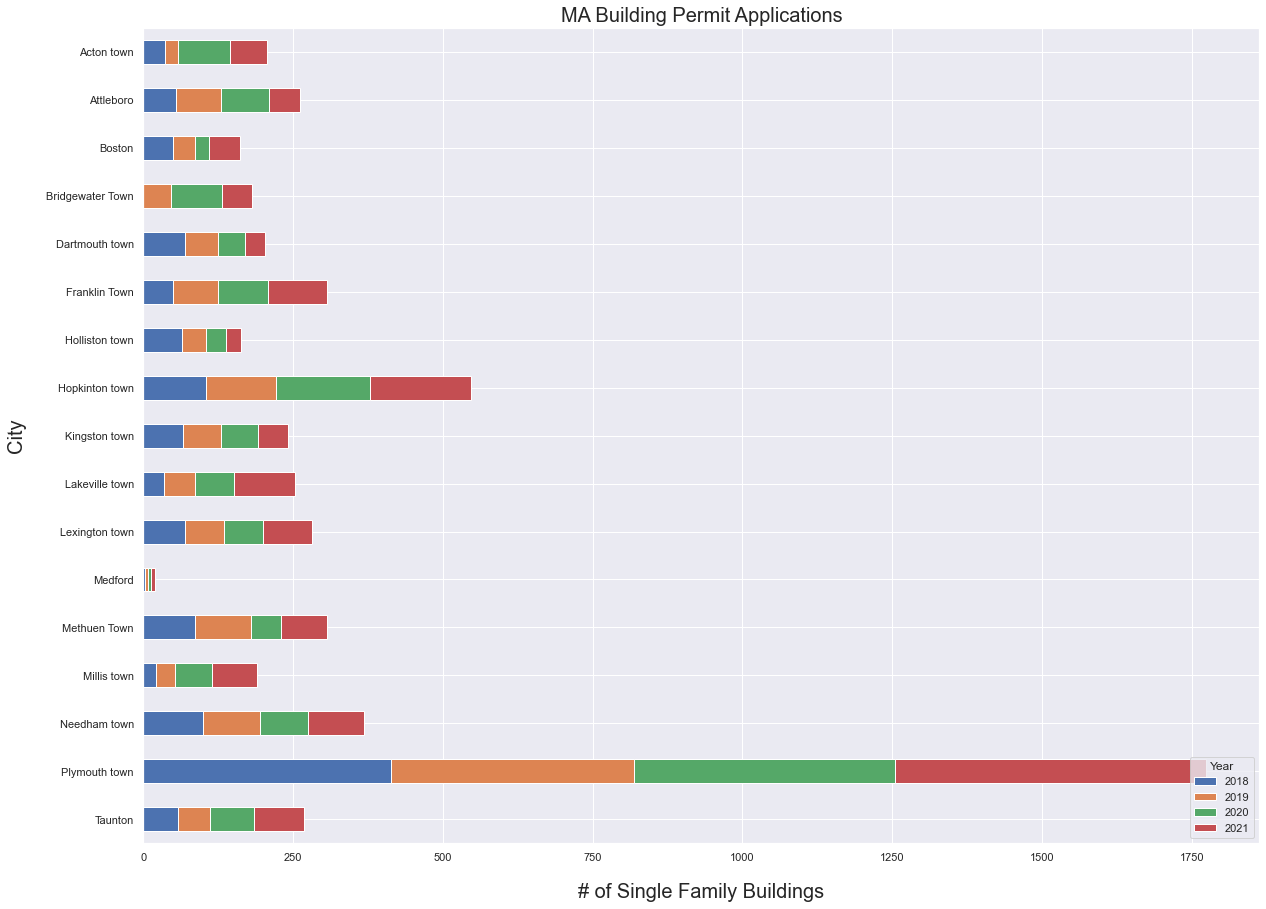

In [48]:
ax = top_singlepiv.plot.barh(stacked = True, \
                        figsize = [20,15], \
                        title = 'MA Building Permit Applications')
ax.set_xlabel('# of Single Family Buildings', fontsize = 20, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('City', fontsize = 20, labelpad = 20)
plt.yticks(rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
ax.set_title('MA Building Permit Applications', fontsize = 20)
ax.legend(title = 'Year', loc = 4)

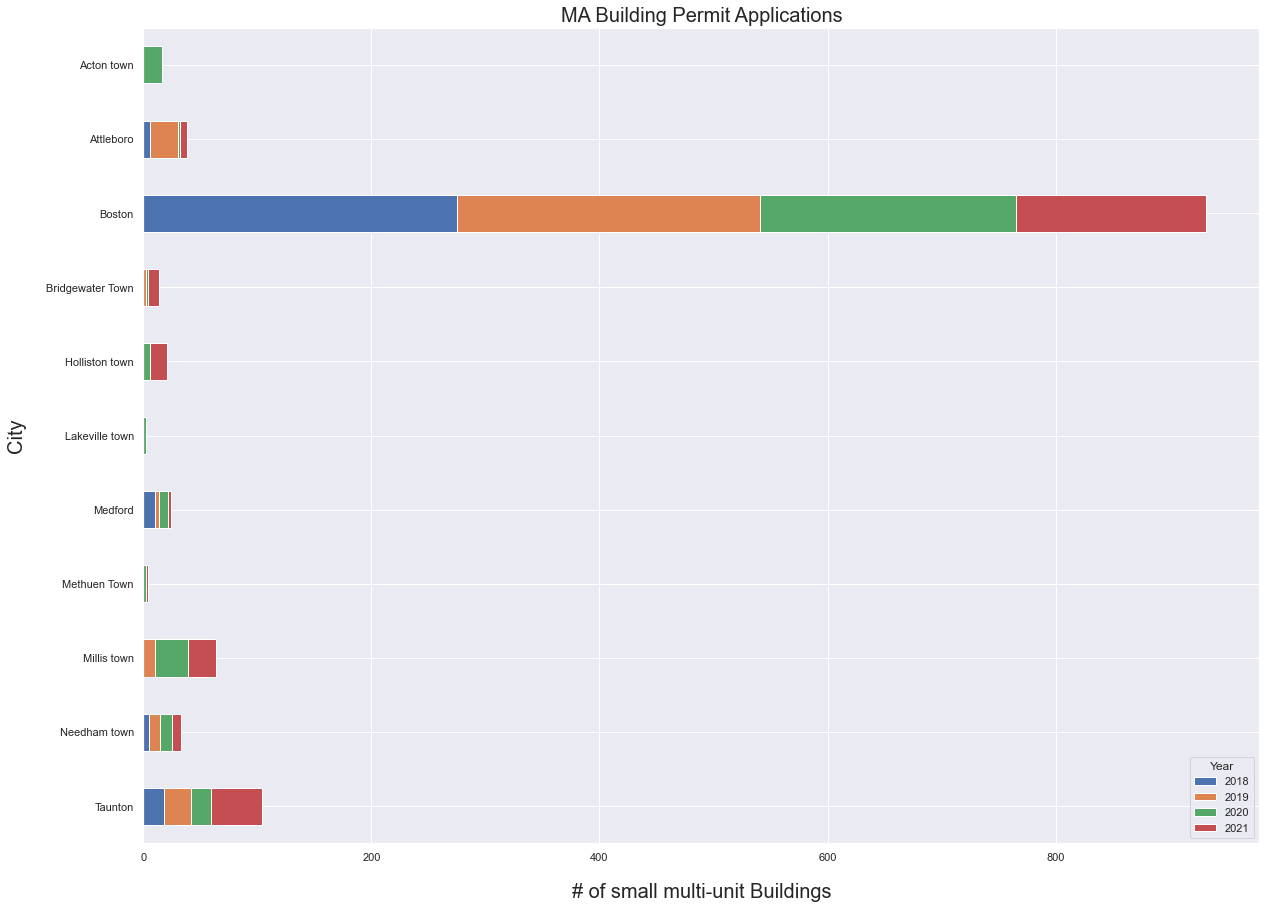

In [49]:
ax = top_smallpiv.plot.barh(stacked = True, \
                        figsize = [20,15], \
                        title = 'MA Building Permit Applications')
ax.set_xlabel('# of small multi-unit Buildings', fontsize = 20, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('City', fontsize = 20, labelpad = 20)
plt.yticks(rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
ax.set_title('MA Building Permit Applications', fontsize = 20)
ax.legend(title = 'Year', loc = 4)

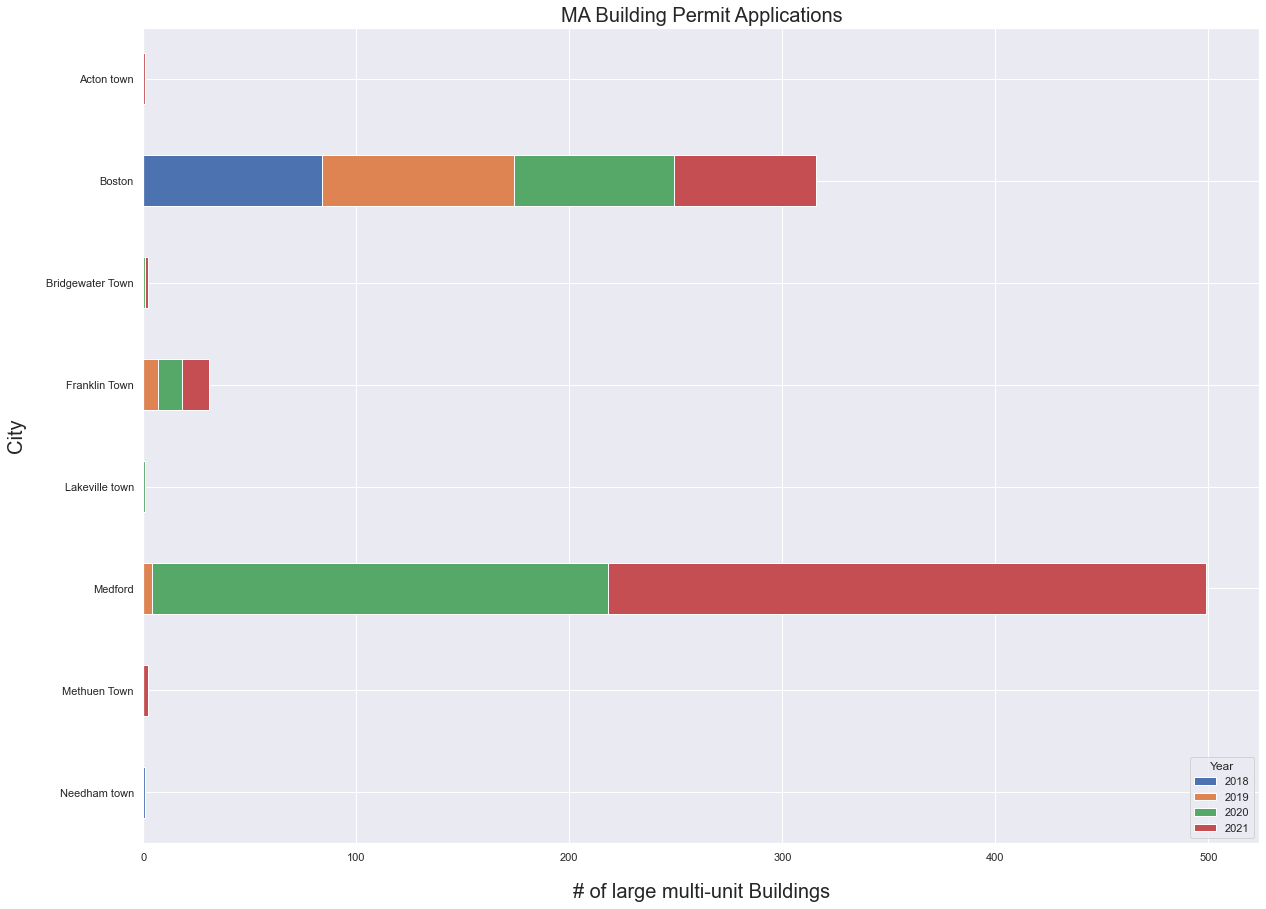

In [50]:
ax = top_lrgepiv.plot.barh(stacked = True, \
                        figsize = [20,15], \
                        title = 'MA Building Permit Applications')
ax.set_xlabel('# of large multi-unit Buildings', fontsize = 20, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('City', fontsize = 20, labelpad = 20)
plt.yticks(rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
ax.set_title('MA Building Permit Applications', fontsize = 20)
ax.legend(title = 'Year', loc = 4)

# 4. Hypothesis Testing

Did places within urban areas see a statistical difference in building permit submissions vs towns in urban places before and after the MA State of Emergency (SOE) implementation? Null hypothesis is that there is no difference.

In [51]:
ma_df['covid_ref'] = ma_df['date'].apply(lambda val: 'post_lockdown' if val >= pd.to_datetime('2020-03-10')\
                                         else ('pre_lockdown'))

In [52]:
ma_df.head()

,date,State,6-Digit,County,FIPS Place,FIPS MCD,Pop,CSA,CBSA,Zip,Place,1-unit_bldgs,1-unit_units,1-unit_value,2-units_bldgs,2-unit_units,2-unit_value,3-4-units_bldgs,3-4-unit_units,3-4-unit_value,5_plus-units_bldgs,5_plus-units_units,5_plus-units_value,classif,year,month,total_buildings,total_small_units,county_name,covid_ref
0,2010-01-01,25,1000,23,NaN,00170,14605.0,148,14460,02351,Abington town,1,1,231556,0,0,0,0,0,0,0,0,0,UP,2010,1,1,0,Plymouth County,pre_lockdown
1,2010-01-01,25,3000,17,NaN,00380,20331.0,148,14460,01720,Acton town,0,0,0,0,0,0,0,0,0,0,0,0,UP,2010,1,0,0,Middlesex County,pre_lockdown
2,2010-01-01,25,9000,13,00765,00765,28144.0,999,44140,01001,Agawam,3,3,544000,1,2,148000,0,0,0,0,0,0,UP,2010,1,4,2,Hampden County,pre_lockdown
3,2010-01-01,25,13000,9,NaN,01185,16450.0,148,14460,01913,Amesbury town,0,0,0,0,0,0,0,0,0,0,0,0,UP,2010,1,0,0,Essex County,pre_lockdown
4,2010-01-01,25,17000,9,NaN,01465,31247.0,148,14460,01810,Andover town,2,2,1737781,0,0,0,0,0,0,0,0,0,UP,2010,1,2,0,Essex County,pre_lockdown


In [53]:
SOE_df = ma_df.query('classif != "R"')
SOE_df['covid_ref'].value_counts()

pre_lockdown     24173
post_lockdown     4647
Name: covid_ref, dtype: int64

In [54]:
SOE_table = pd.pivot_table(SOE_df, index = ['classif', 'covid_ref'], values = ['total_buildings'], aggfunc = np.sum)

In [55]:
SOE_table

total_buildings
classif covid_ref                     
UA      post_lockdown             3407
        pre_lockdown             11848
UP      post_lockdown             8613
        pre_lockdown             44795

In [56]:
ua_up_contingency = [[2965, 3011],
                    [7157, 8716]]

chi2, pval, dof, expected = chi2_contingency(ua_up_contingency)

In [57]:
print(pval)

2.4422639976871267e-09


## Findings

Using the standard p-value statistical significance threshold = 0.05, we see that our p-value is much smaller than the specified threshold. This indicates there is a significant statistical difference between the building permit submission rate pre and post Massachusetts state of emergency implementation.